# Image handling and basic operations

Welcome to ECE4076. Let's start by finding a random picture on your computer and copying this into the folder with this notebook. If you are using [Google Colab](https://colab.research.google.com/), upload the image by clicking the files icon on the left of the colab window, and the upload to session storage.

For most of this unit, we will be using [OpenCV](https://opencv.org/) for image handling and [Numpy](https://numpy.org/) numerical operations. Sometimes we will re-implement existing functions in this library to aid our understanding.

We'll be using Python, because it has really nice tools for computer vision. If you are transitioning from MATLAB, I recommend bookmarking [numpy for matlab users](https://numpy.org/doc/stable/user/numpy-for-matlab-users.html).

In [1]:
# Lets import some libraries 
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [2]:
# My image is called im.png and stored in a subfolder ./test_images/
im = cv2.imread('../test_images/im.png')
myimg = cv2.imread('../test_images/penguin.jpg')

An image is typically represented using a 3D array. It has width, height and depth. Depth is typically used to store colours. We also talk about rows, columns and channels.

In [3]:
print("The image size is: ",im.shape)
print("Images are typically stored as 8 bit unsigned integers. Type: ",im.dtype)
print("This means an image comprises values between 0 and 255.")

The image size is:  (801, 773, 3)
Images are typically stored as 8 bit unsigned integers. Type:  uint8
This means an image comprises values between 0 and 255.


We'll use matplotlib to display our image, but it looks a bit weird because opencv loads images in Blue-Green-Red colour order, but matplotlib expects Red-Green-Blue colour order.

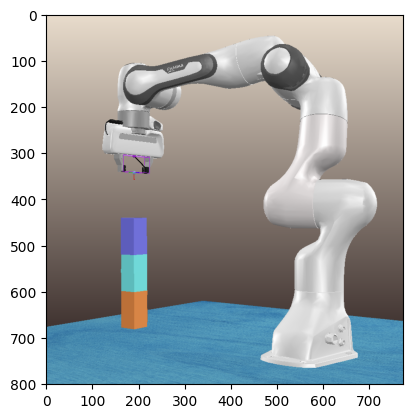

In [4]:
plt.imshow(im)
plt.show()

Let's plot the same image, with the channels re-ordered. That looks better. The [:,:, ] notation means take all the rows, all the columns, and the bracketed [2,1,0] tells us to take the channels in reverse order.

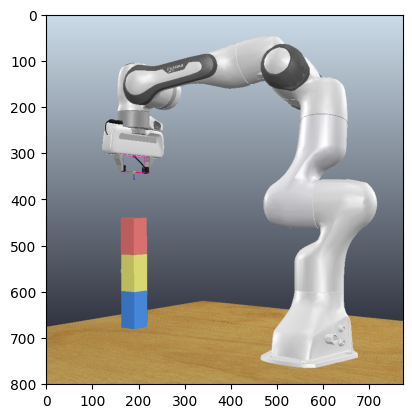

In [5]:
plt.imshow(im[:,:,[2,1,0]])
plt.show()

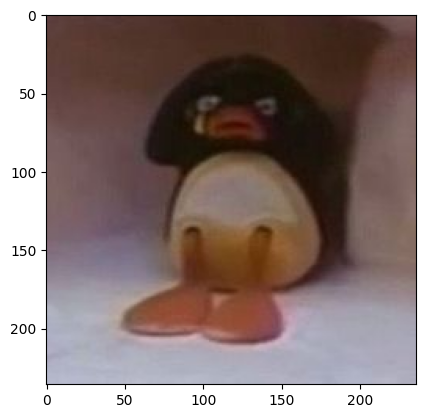

In [13]:
# we need to rearrange colour channels to display proper image
plt.imshow(myimg[:,:,[2,1,0]])
plt.show()

Since our image is just a grid of numbers, we can access individual pixels by indexing. Here, we go to a particular row and column, and take a slice through the channels.

In [6]:
print("The pixel value at row 10, column 10 is",myimg[10,10,:])

The pixel value at row 10, column 10 is [58 64 93]


One way to think about an image is a signal representation. Lets take a row of the image and plot it as a 1D signal. We'll plot each channel separately. This graph makes sense, we see a clear increase in the red channel at column 200, corresponding to the red block, and again at the robot arm (white is a combination of all colours) 

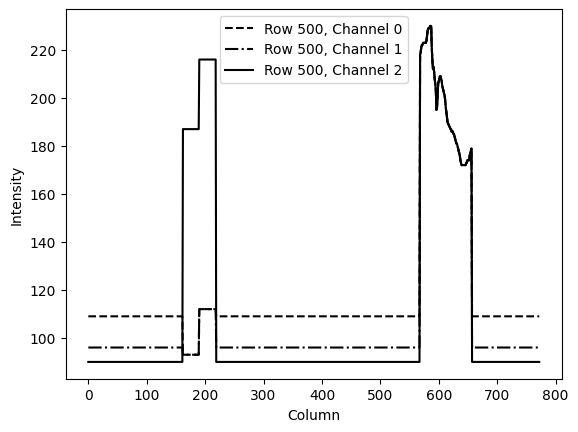

In [7]:
plt.plot(im[500,:,0],'k--',label="Row 500, Channel 0") # Blue channel
plt.plot(im[500,:,1],'k-.',label="Row 500, Channel 1") # Green channel
plt.plot(im[500,:,2],'k-',label="Row 500, Channel 2") # Red channel
plt.ylabel('Intensity')
plt.xlabel('Column')
plt.legend()
plt.show()

## Activity 1

This image was synthetically rendered, so shows very clear transitions. Try to choose a different row to plot for your image, and re-run the code above and see if you can interpret this yourself. 

- How does this change for natural, real world images?
- What happens at the edges of objects?

Now try to modify the code above to plot columns instead of rows.

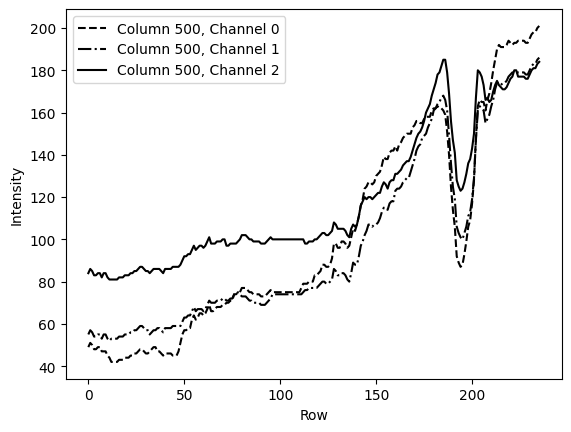

In [8]:
plt.plot(myimg[:,50,0],'k--',label="Column 500, Channel 0") # Blue channel
plt.plot(myimg[:,50,1],'k-.',label="Column 500, Channel 1") # Green channel
plt.plot(myimg[:,50,2],'k-',label="Column 500, Channel 2") # Red channel
plt.ylabel('Intensity')
plt.xlabel('Row')
plt.legend()
plt.show()

Thinking about an image as a 2D intensity signal leads to the first technique that we will explore for computer vision, using filters to extract information from the image. We'll start to explore this in more detail next week. 

### Image Cropping

Let's crop our image, I am going to extract a patch around the blocks in my image.  

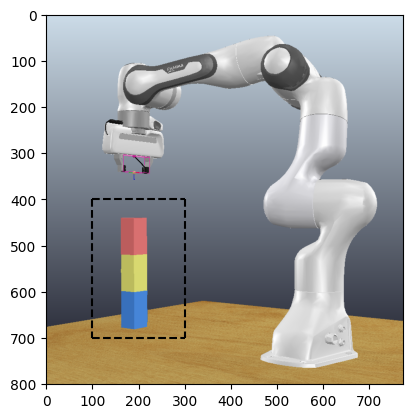

In [9]:
# making box
plt.imshow(im[:,:,[2,1,0]])
plt.plot([100,300],[400,400],'k--') # Top line
plt.plot([100,300],[700,700],'k--') # Bottom line
plt.plot([100,100],[400,700],'k--') # Left line
plt.plot([300,300],[400,700],'k--') # Right line
plt.show()

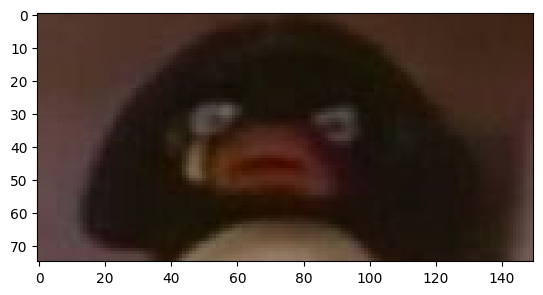

In [24]:
# Take a slice of the image and assign it to a new variable, reorder the channels at the same time
im_crop = im[400:700,100:300,[2,1,0]]
my_crop = myimg[25:100,50:200,[2,1,0]]
plt.imshow(im_crop)
plt.imshow(my_crop)
plt.show()

In [82]:
# Since our image is just a grid of numbers, we can perform mathematical operations on the whole image
mu_red = np.mean(im_crop[:,:,0])
mu_green = np.mean(im_crop[:,:,1])
mu_blue = np.mean(im_crop[:,:,2])
print("Average pixel intensity in each channel: ",mu_red,mu_green,mu_blue)

sd_red = np.std(im_crop[:,:,0])
sd_green = np.std(im_crop[:,:,1])
sd_blue = np.std(im_crop[:,:,2])
print("Standard deviation of pixel intensity in each channel: ",sd_red,sd_green,sd_blue)

Average pixel intensity in each channel:  115.52186666666667 110.56328333333333 106.58263333333333
Standard deviation of pixel intensity in each channel:  51.31810455562658 34.741588361593216 33.34020253486106


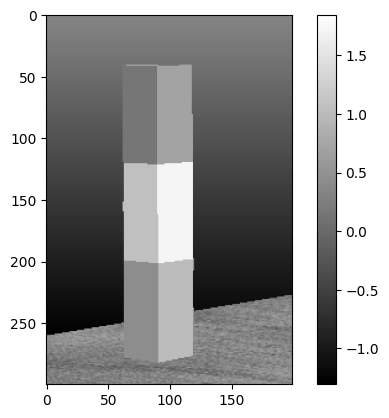

In [83]:
# For example, lets normalise and average our image channels to single channel
im_op = 1/3*((im_crop[:,:,0]-mu_red)/sd_red + (im_crop[:,:,1]-mu_green)/sd_green + (im_crop[:,:,2]-mu_blue)/sd_blue)

plt.imshow(im_op,cmap='gray')
plt.colorbar()
plt.show()

Lets look at the distribution of the colours in an image, by calculating a histogram for each channel

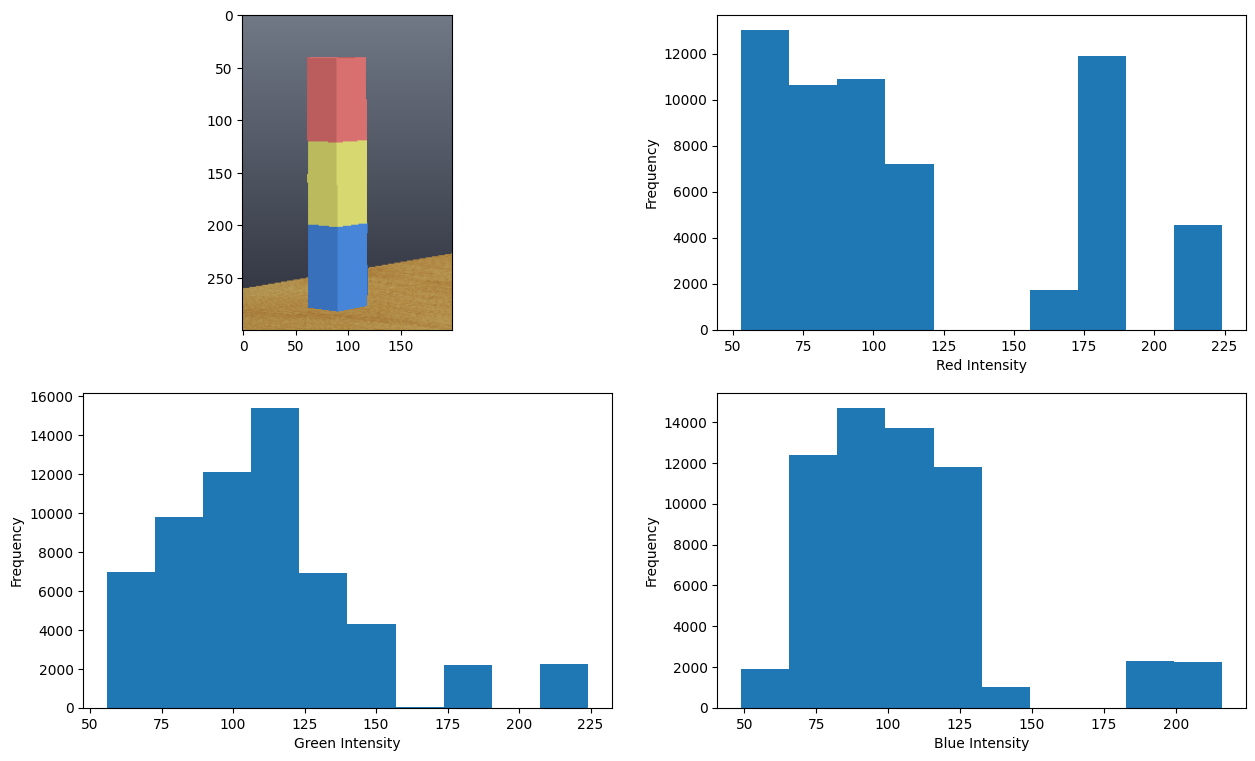

In [84]:
plt.figure(figsize=(15,9))

plt.subplot(2,2,1)
plt.imshow(im_crop)
plt.subplot(2,2,2)
# The ravel command rearanges our image into a long column vector of intensities
plt.hist(im_crop[:,:,0].ravel())
plt.xlabel('Red Intensity')
plt.ylabel('Frequency')
plt.subplot(2,2,3)
plt.hist(im_crop[:,:,1].ravel())
plt.xlabel('Green Intensity')
plt.ylabel('Frequency')
plt.subplot(2,2,4)
plt.hist(im_crop[:,:,2].ravel())
plt.xlabel('Blue Intensity')
plt.ylabel('Frequency')
plt.show()

Most of the pixels in this image are dark grey, so we see a lot of pixels with low intensities. We also see a few isolated peaks in specific regions of the image.

Now, I will try to threshold the image using some logical operations, to extract the yellow block, and ignore everything else. I will use the histogram above to choose the thresholds. Yellow is formed using equal combinations of red and green, so I'll also use this to help guide the selection. This technique is useful for chroma-keying.

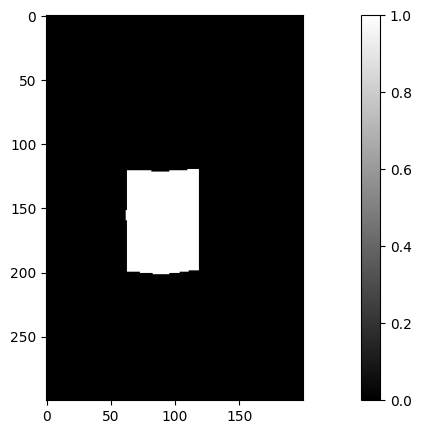

In [85]:
im_yellow = (im_crop[:,:,1] > 170) & (im_crop[:,:,0] > 150) # pixels where yellow block is present
plt.figure(figsize=(15,5))
plt.imshow(im_yellow, cmap='gray')
plt.colorbar()
plt.show()


In [61]:
x,y = np.where(im_yellow==1) # Find where yellow pixel mask is true.
print("The mean row of the yellow pixels is: ", np.mean(x))
print("The mean column of the yellow pixels is: ", np.mean(y))

The mean row of the yellow pixels is:  160.36096795877214
The mean column of the yellow pixels is:  90.43782209276272


## Activity 2

Crop a different region of your image and re-run the code above.

- What does the distribution of the colours look like for your image patch?
- Can you come up with a series of logical operations and thresholds to extracts an object from your image?
- Think about the pre-recorded videos on light, image formation and human vision receptors. Why do you think this approach works better on my synthetic image than yours? 


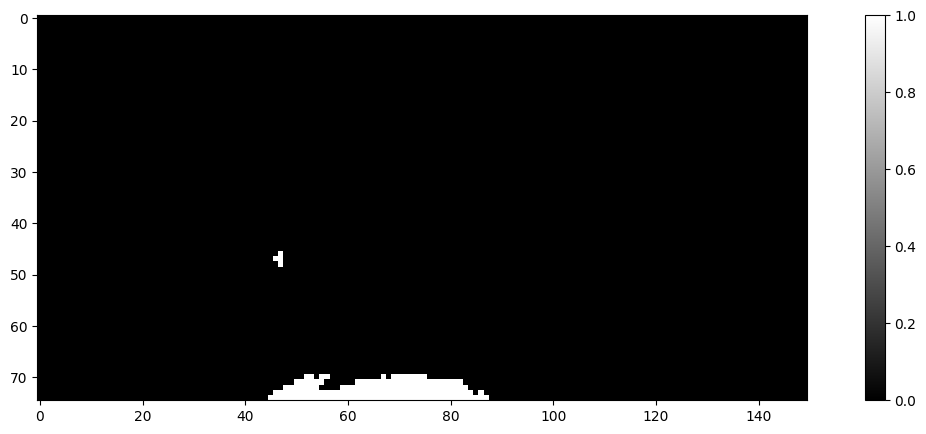

In [27]:
myimg_o = (my_crop[:,:,1] > 100) & (my_crop[:,:,0] > 100)
plt.figure(figsize=(15,5))
plt.imshow(myimg_o, cmap='gray')
plt.colorbar()
plt.show()

### How much information is in an image?

Ok, we've seen a very primitive way of extracting information from an image. It isn't very effective, unless you have a very controlled environment. But treating an image as a bag of independent pixels is really not a good idea. Let's illustrate this using some information theory. 

We can calculate the entropy (or amount of information) in a signal using the equation:

$h(X) = -\sum_{i=1}^N p(x_i)log p(x_i)$

Lets use the histogram above as an estimate of the probability a pixel may take on a given intensity in an image. To make this easier, I will only consider the blue channel of the image.

In [15]:
# Here's a function to calculate image entropy
def entropy(im):
    prob, bins = np.histogram(im.ravel(),density=True,bins=np.linspace(0,255,256,dtype=int)) 
    prob = prob+1e-12 # Add a small non-zero probability to avoid log(0) problems
    entropy = -np.sum(np.log2(prob)*prob)
    return entropy

In [16]:
print("The entropy (in bits) of our cropped image patch blue channel is: ",entropy(im_crop[:,:,0]))

The entropy (in bits) of our cropped image patch blue channel is:  6.0427094180239855


Lets compare this with the entropy of a randomly generated set of numbers.

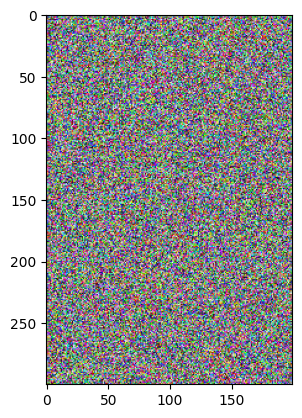

The entropy (in bits) of our cropped random image blue channel is:  7.991496796864057


In [17]:
# Create a grid of random numbers same shape as our image patch
im_rand = np.random.randint(0,255,im_crop.shape) 
plt.imshow(im_rand)
plt.show()

print("The entropy (in bits) of our cropped random image blue channel is: ",entropy(im_rand[:,:,0]))

Good, our random image has more entropy than our actual image. This is useful for image compression - and you can actually use jpeg filesize as a neat measure of the entropy of an image. 

But there isn't as much difference as you'd think. That's because thinking about an image as a bag of pixels really doesn't make any sense. 

The entropy (in bits) of our cropped random image blue channel is:  6.0427094180239855


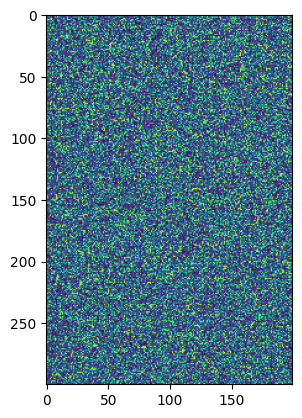

In [18]:
# Vectorise, randomly shuffle, then reshape into an image
im_crop_random_shuffle = im_crop[:,:,0].ravel()
np.random.shuffle(im_crop_random_shuffle)
im_crop_random_shuffle = im_crop_random_shuffle.reshape((im_crop.shape[0],im_crop.shape[1]))

print("The entropy (in bits) of our cropped random image blue channel is: ",entropy(im_crop_random_shuffle))

plt.imshow(im_crop_random_shuffle)
plt.show()

The entropy hasn't changed, but the image has lost almost all it's information. Images are not bags of pixels! They have strong local spatial information. There is more information in the frequency (change in pixels as a function of space), than in the amplitude. So we need tools that explicitly take this into account. Next week, we will start to look at filters that enable this.